In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU,Dropout
import librosa

In [3]:
def df_to_vector_array(df,
                       sampling_rate = 48000,
                       hop_length = 2048,
                       n_fft = 65536):
    ample_array = np.array(df.loc[:,'ample'])
    n_fft = n_fft

    # フレームごとのシフトサイズ（一般的には `n_fft // 4` など）
    hop_length = hop_length

    # メルスペクトログラムの生成
    mel_spectrogram = librosa.feature.melspectrogram(y=ample_array, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length)

    # MFCC の計算 (13係数で設定)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), n_mfcc=13)

    return mfccs

In [4]:
training_data = []
x_train = []
y_train = []
data_frames = []

for i in range(8):
    if(i == 3 or i == 7):
        continue
    path_to_mfcc_coord = f'../data/20240509/processed/mfcc_coordinate{i}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames.append(df)
    
combined_df = pd.concat(data_frames, ignore_index=True)

y_columns_to_use = [f'mfcc_{i}' for i in range(13)]

y_train = combined_df[y_columns_to_use].values

x_columns_to_use = ['x','y']
x_train = combined_df[x_columns_to_use].values

In [5]:
data_frames_abnormal = []
for i in range(2):
    path_to_mfcc_coord = f'../data/20240509/processed/abnormal_mfcc_coordinate{i}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames_abnormal.append(df)
    
combined_df_abnormal = pd.concat(data_frames_abnormal, ignore_index=True)

y_columns_to_use = [f'mfcc_{i}' for i in range(13)]

y_test_abnormal = combined_df_abnormal[y_columns_to_use].values

x_columns_to_use = ['x','y']
x_test_abnormal = combined_df_abnormal[x_columns_to_use].values

In [6]:
x_test_abnormal

array([[ 0.91835545, -1.83338221],
       [ 0.91835545, -1.83338221],
       [ 0.91835545, -1.83338221],
       ...,
       [-0.95799253,  1.22751213],
       [-0.98308017,  1.26234719],
       [-0.96717604,  1.23448191]])

In [7]:
data_frames_normal = []

for i in range(2):
    path_to_mfcc_coord = f'../data/20240509/processed/normal_mfcc_coordinate{i*4+3}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames_normal.append(df)
    
combined_df_normal = pd.concat(data_frames_normal, ignore_index=True)
y_columns_to_use = [f'mfcc_{i}' for i in range(13)]

y_test_normal = combined_df_normal[y_columns_to_use].values

x_columns_to_use = ['x','y']
x_test_normal = combined_df_normal[x_columns_to_use].values

In [8]:
def min_max_scaler(arr,min_val,max_val):
    arr = (arr-min_val)/(max_val-min_val)   
    arr = np.where(arr < 0, 0, arr)
    arr = np.where(arr > 1, 1, arr)
    return arr

In [9]:
std_weight = 3
for idx in range(y_train.shape[1]):
    mean_val = y_train[:,idx].mean()
    std_val = y_train[:,idx].std()
    max_val = mean_val + std_weight*std_val
    min_val = mean_val - std_weight*std_val
    y_train[:,idx] = min_max_scaler(y_train[:,idx], min_val, max_val)
    y_test_abnormal[:,idx] = min_max_scaler(y_test_abnormal[:,idx], min_val, max_val)
    y_test_normal[:,idx] = min_max_scaler(y_test_normal[:,idx], min_val, max_val)

In [10]:
x_train.shape, y_train.shape

((7369, 2), (7369, 13))

In [12]:
# 必要なライブラリのインポート
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


# トレーニングデータと検証データに分割
x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# モデルのパラメータ設定
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}
verbose_eval = 1

# 各ターゲットごとにモデルを作成
models = []
for i in range(13):
    train_data = lgb.Dataset(x_train_split, label=y_train_split[:, i])
    val_data = lgb.Dataset(x_val, label=y_val[:, i], reference=train_data)

    # モデルのトレーニング
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=10, 
                    verbose=True), # early_stopping用コールバック関数
                lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
    )
    models.append(model)

# 予測を行い評価
y_pred = np.zeros((x_val.shape[0], 13))
for i, model in enumerate(models):
    y_pred[:, i] = model.predict(x_val, num_iteration=model.best_iteration)

# パフォーマンス評価
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'Validation RMSE: {rmse:.4f}')


[1]	training's rmse: 0.15529	valid_1's rmse: 0.160384
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 0.148201	valid_1's rmse: 0.152882
[3]	training's rmse: 0.14226	valid_1's rmse: 0.146573
[4]	training's rmse: 0.137071	valid_1's rmse: 0.141206
[5]	training's rmse: 0.132784	valid_1's rmse: 0.136796
[6]	training's rmse: 0.129128	valid_1's rmse: 0.133047
[7]	training's rmse: 0.126105	valid_1's rmse: 0.129972
[8]	training's rmse: 0.12348	valid_1's rmse: 0.127462
[9]	training's rmse: 0.121137	valid_1's rmse: 0.125317
[10]	training's rmse: 0.119119	valid_1's rmse: 0.123312
[11]	training's rmse: 0.117455	valid_1's rmse: 0.121848
[12]	training's rmse: 0.116078	valid_1's rmse: 0.120545
[13]	training's rmse: 0.114801	valid_1's rmse: 0.119408
[14]	training's rmse: 0.113744	valid_1's rmse: 0.118459
[15]	training's rmse: 0.11282	valid_1's rmse: 0.117809
[16]	training's rmse: 0.111991	valid_1's rmse: 0.117184
[17]	training's rmse: 0.111376	valid_1's rmse: 0.116735


c:\Users\kenta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
x_test_normal

array([[ 0.91904483, -1.83761862],
       [ 0.91904483, -1.83761862],
       [ 0.91904483, -1.83761862],
       ...,
       [-1.22025104,  1.2705492 ],
       [-1.21056552,  1.25089115],
       [-1.20160213,  1.23520351]])

c:\Users\kenta\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
c:\Users\kenta\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
c:\Users\kenta\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
c:\Users\kenta\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:

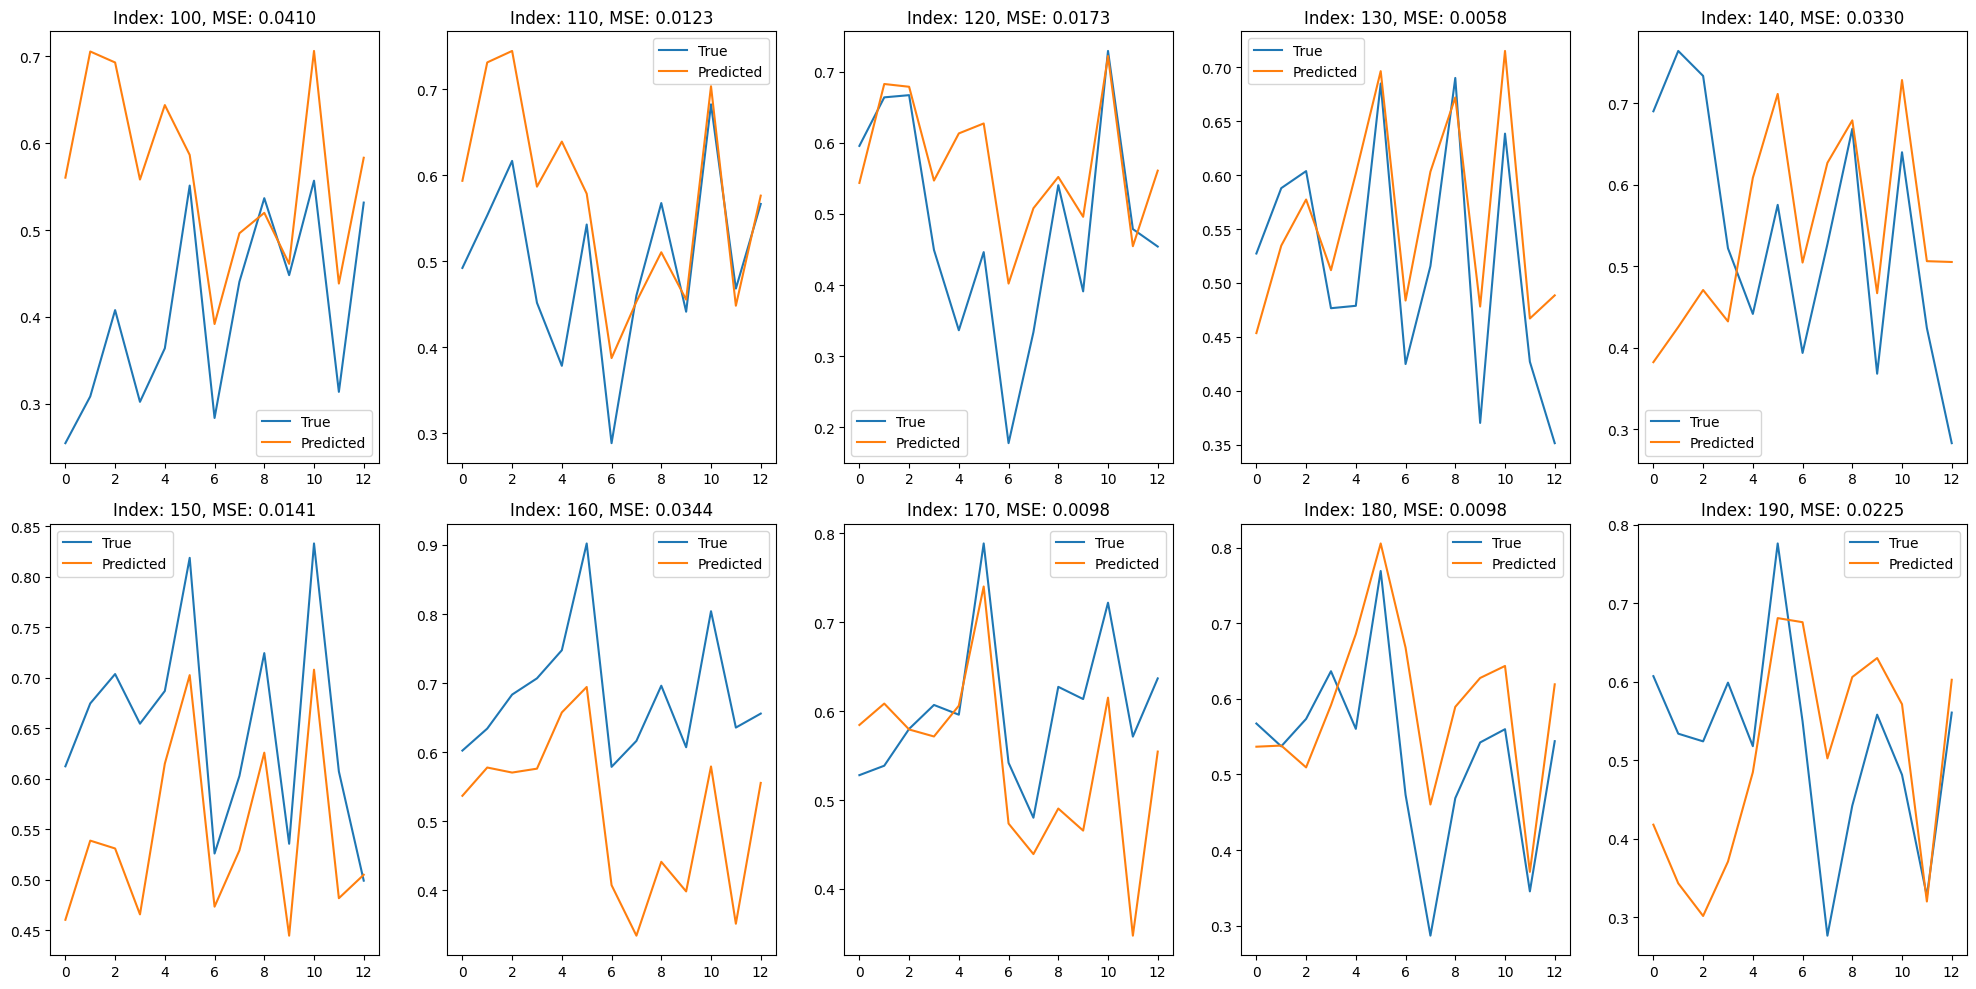

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Configuration
start_index = 100  # グラフの開始インデックス
num_graphs = 10  # 作成するサブプロットの数
index_step = 10  # グラフ間のインデックス間隔

# グラフ全体の設定
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # 必要に応じて行・列数を調整
axs = axs.flatten()  # 1次元配列にフラット化

# サブプロットごとにグラフを描画
for i in range(num_graphs):
    current_index = start_index + i * index_step
    x = np.expand_dims(x_test_normal[current_index], axis=0)  # 入力データの形状調整

    # 13次元の全モデルの予測出力を格納
    y_predicted = np.zeros((13,))
    for j, model in enumerate(models):
        y_predicted[j] = model.predict(x, num_iteration=model.best_iteration)
    # 平均二乗誤差の計算
    mse = mean_squared_error(y_predicted, y_test_normal[current_index])

    # 現在のサブプロットに元の値と予測値をプロット
    axs[i].plot(y_test_normal[current_index].T, label='True')
    axs[i].plot(y_predicted.T, label='Predicted')
    axs[i].set_title(f'Index: {current_index}, MSE: {mse:.4f}')
    axs[i].legend()

# レイアウトを調整し、グラフを表示
plt.tight_layout()
plt.show()


In [15]:
y_predicted_normal = []

for i in range(x_test_normal.shape[0]):
    x = np.expand_dims(x_test_normal[i], axis=0)  # 入力データの形状調整

    # 13次元の全モデルの予測出力を格納
    y_predicted = np.zeros((13,))
    for j, model in enumerate(models):
        y_predicted[j] = model.predict(x, num_iteration=model.best_iteration)
    y_predicted_normal.append(y_predicted)

y_predicted_normal = np.array(y_predicted_normal)

c:\Users\kenta\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


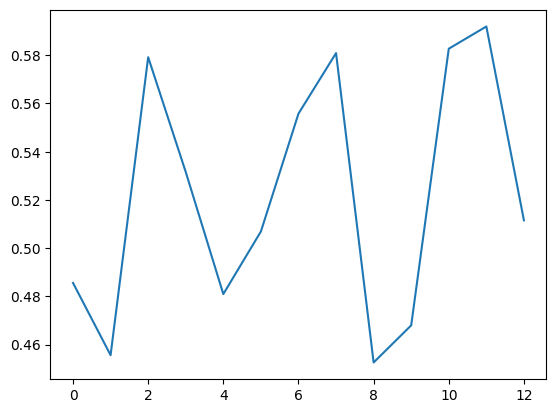

In [16]:
plt.plot(y_predicted_normal[1000])

In [17]:
y_predicted_abnormal = []

for i in range(x_test_abnormal.shape[0]):
    x = np.expand_dims(x_test_abnormal[i], axis=0)  # 入力データの形状調整

    # 13次元の全モデルの予測出力を格納
    y_predicted = np.zeros((13,))
    for j, model in enumerate(models):
        y_predicted[j] = model.predict(x, num_iteration=model.best_iteration)
    y_predicted_abnormal.append(y_predicted)

y_predicted_abnormal = np.array(y_predicted_abnormal)

In [18]:
y_predicted_abnormal.shape

(2457, 13)

In [19]:
mses_normal = []
for i in range(y_predicted_normal.shape[0]):
    mse = mean_squared_error(y_predicted_normal[i],y_test_normal[i])
    mses_normal.append(mse)

In [20]:
mses_abnormal = []
for i in range(y_predicted_abnormal.shape[0]):
    mse = mean_squared_error(y_predicted_abnormal[i],y_test_abnormal[i])
    mses_abnormal.append(mse)

<Axes: >

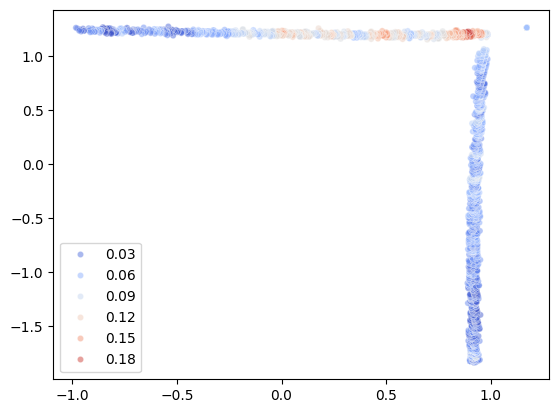

In [21]:
import seaborn as sns
sns.scatterplot(
    x=x_test_abnormal[:,0],
    y=x_test_abnormal[:,1],
    hue=mses_abnormal,
    s=20,
    alpha=0.5,
    palette='coolwarm'
)

<Axes: >

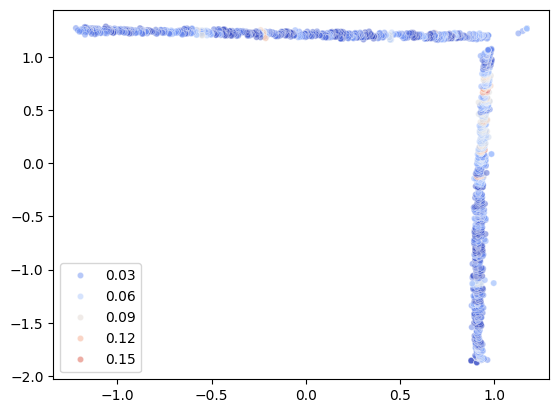

In [22]:
import seaborn as sns
sns.scatterplot(
    x=x_test_normal[:,0],
    y=x_test_normal[:,1],
    hue=mses_normal,
    s=20,
    alpha=0.5,
    palette='coolwarm'
)

<Axes: xlabel='mse', ylabel='Count'>

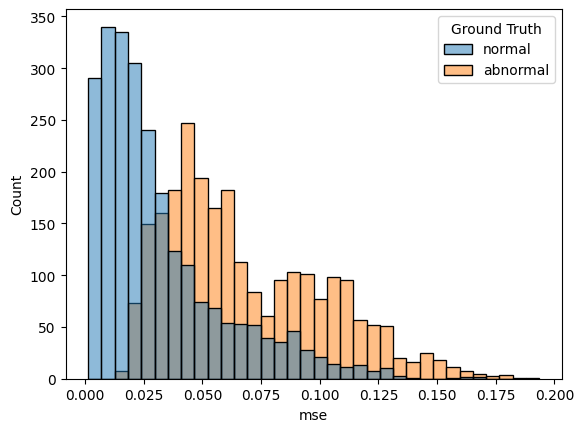

In [23]:
plt_df_normal = pd.DataFrame({'mse':mses_normal})
plt_df_normal['Ground Truth'] = 'normal'
plt_df_abnormal = pd.DataFrame({'mse':mses_abnormal})
plt_df_abnormal['Ground Truth'] = 'abnormal'

plt_df = pd.concat([plt_df_normal, plt_df_abnormal], ignore_index=True)
sns.histplot(
    data=plt_df,
    x='mse',
    hue='Ground Truth'
)


In [24]:
plt_df['Label'] = plt_df['Ground Truth']=='abnormal'
plt_df

,mse,Ground Truth,Label
0,0.006558,normal,False
1,0.006576,normal,False
2,0.006592,normal,False
3,0.006594,normal,False
4,0.006584,normal,False
...,...,...,...
4908,0.029012,abnormal,True
4909,0.032761,abnormal,True
4910,0.034510,abnormal,True
4911,0.036318,abnormal,True


In [25]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# Min-Maxスケーリング
scaler = MinMaxScaler()
y_scores_scaled = scaler.fit_transform(np.array(plt_df['mse']).reshape(-1, 1)).flatten()

# AUC計算
auc = roc_auc_score(plt_df['Label'], y_scores_scaled)
# 結果の出力
print(f"AUC: {auc:.4f}")


AUC: 0.8289
